In [38]:
from tsfel.feature_extraction import features as tsfelf
import numpy as np
import os
from scipy import signal
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

In [6]:
def hpf(arr,fs,lf,order):
    wbut = lf
    bbut, abut = signal.butter(order,wbut, btype='highpass', fs=fs)
    return signal.filtfilt(bbut, abut, arr)

def get_features(sig,label,fs = 44100):
    
    s_f = hpf(sig, fs, 65, 2)

    Zero_Cross = tsfelf.zero_cross(sig)
    Zero_Cross_filt = tsfelf.zero_cross(s_f)
            
    Spectral_centroid = tsfelf.spectral_centroid(sig, fs)
    Spectral_centroid_filt = tsfelf.spectral_centroid(s_f, fs)

    Spectral_spread = tsfelf.spectral_spread(sig, fs)
    Spectral_spread_filt = tsfelf.spectral_spread(s_f, fs) 
            
    STD = np.std(sig)
    STD_filt = np.std(s_f)
    
    RMS = tsfelf.rms(sig)
    RMS_filt= tsfelf.rms(s_f)
    
    kurt_filt = tsfelf.kurtosis(s_f)
    
    return [label, RMS, RMS_filt, Zero_Cross, Zero_Cross_filt, Spectral_centroid, 
     Spectral_centroid_filt, Spectral_spread, Spectral_spread_filt, STD, STD_filt, kurt_filt]

In [28]:
cwd = os.getcwd()
print(os.listdir(cwd))
#cwd = "C:\\Users\\AtteR\\Documents\\Capstone\\audio_processing\\Phone recordings\\"
wetasphalt_path=cwd+"\\Phone-recording-wet-asphalt.wav"
snow_path = cwd+"\\Phone-recording-snow-loska.wav"

Fs , snow_x = wavfile.read(snow_path)
wa_Fs, wa_x = wavfile.read(wetasphalt_path)
print(len(snow_x)/Fs,len(wa_x)/wa_Fs)
print( Fs,wa_Fs)


['Phone recording snow-loska.mp3', 'Phone recording wet asphalt.mp3', 'Phone-recording-snow-loska.wav', 'Phone-recording-wet-asphalt.wav', 'phone_test.ipynb']
35.08244897959184 36.8065306122449
44100 44100


In [26]:
#we consider/study 3s samples
all_features=[]
number_of_wa_samples=int(len(wa_x) / (3*wa_Fs))
number_of_snow_samples=int(len(snow_x) / (3*Fs))
counter = 0
wa_features=[]
while counter < number_of_wa_samples:
    sample=wa_x[counter*3*wa_Fs:(counter+1)*3*wa_Fs]
    features = get_features(sample,"Wet asphalt",wa_Fs)
    wa_features.append(features)
    counter+=1
counter = 0
snow_features=[]
while counter < number_of_snow_samples:
    sample=snow_x[counter*3*wa_Fs:(counter+1)*3*Fs]
    features = get_features(sample,"Snow",Fs)
    snow_features.append(features)
    counter+=1
print(number_of_wa_samples,len(wa_features),number_of_snow_samples,len(snow_features))
all_features=np.concatenate((wa_features,snow_features))

columnlist=["Label","RMS", "RMS_filt","Zero_Cross", "Zero_Cross_filt", "Spectral_centroid", "Spectral_centroid_filt", "Spectral_spread", \
                        "Spectral_spread_filt", "STD", "STD_filt", "kurt_filt"]
features_df=pd.DataFrame(all_features,columns=columnlist)
features_df.head(23)

12 12 11 11


,Label,RMS,RMS_filt,Zero_Cross,Zero_Cross_filt,Spectral_centroid,Spectral_centroid_filt,Spectral_spread,Spectral_spread_filt,STD,STD_filt,kurt_filt
0,Wet asphalt,11.84390029934529,2216.1630574775454,1934,2762,2749.6443901722096,3571.822404412853,4568.406951478484,4864.728135476897,3762.6230533404646,2216.1630571773135,0.1572069042386368
1,Wet asphalt,5.913404453424508,2441.180053181291,1400,2339,2208.8691735428197,2935.859568139889,4185.50282618633,4564.33297935398,4242.75799600883,2441.179372832663,-0.06036142712670767
2,Wet asphalt,11.966702985688858,2539.956237709434,1512,2729,2409.14764025699,3266.0057540009793,4307.327941650543,4733.431765330471,4407.869250529758,2539.956112094588,-0.19591831721816133
3,Wet asphalt,7.964129236605499,2481.6463630359103,1073,1847,1628.7744098314663,2304.8791516584324,3576.0093215136108,4075.940257257509,4429.833813358151,2481.646170437459,-0.05234576864329821
4,Wet asphalt,9.02700157137543,2652.849084335083,1707,2852,2621.0218448419882,3465.251019762206,4488.11883605754,4816.33855356548,4495.998048196208,2652.848992126169,0.08408454347124916


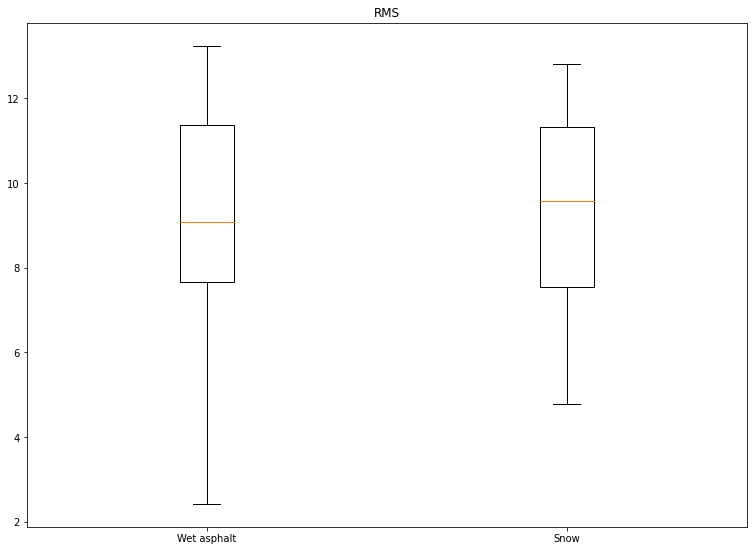

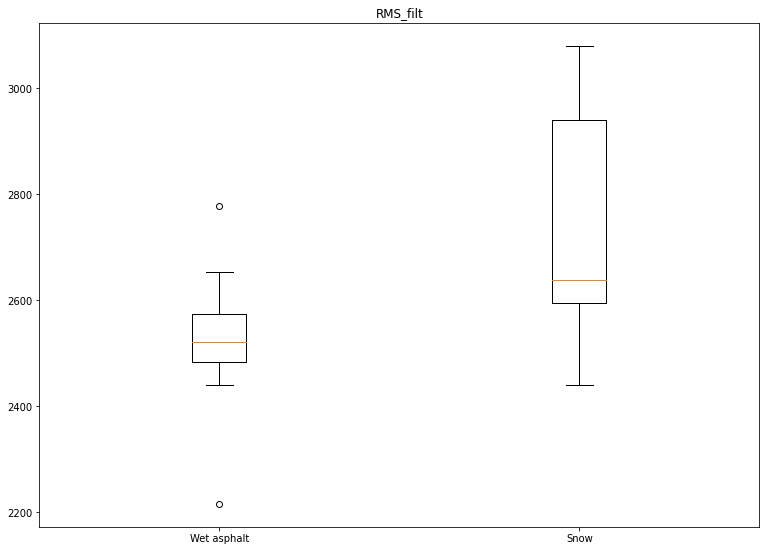

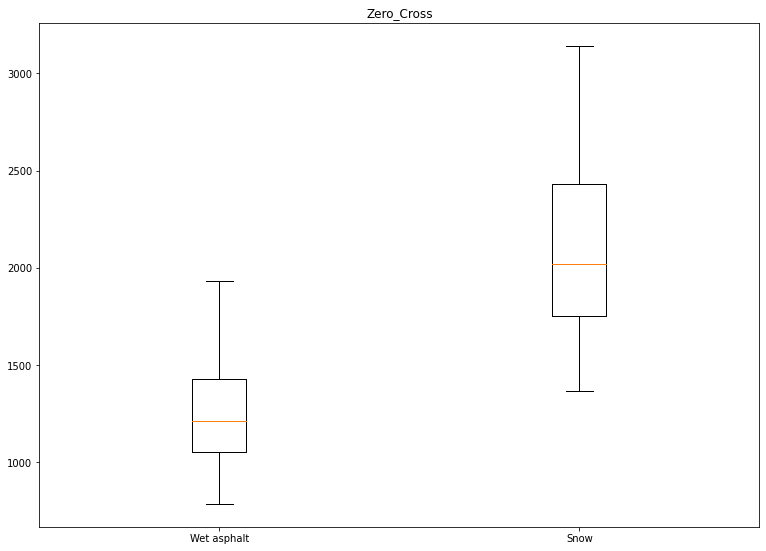

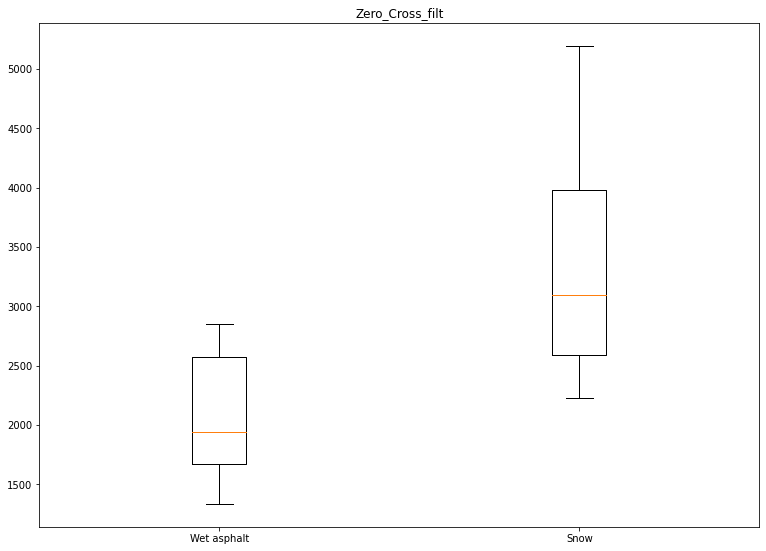

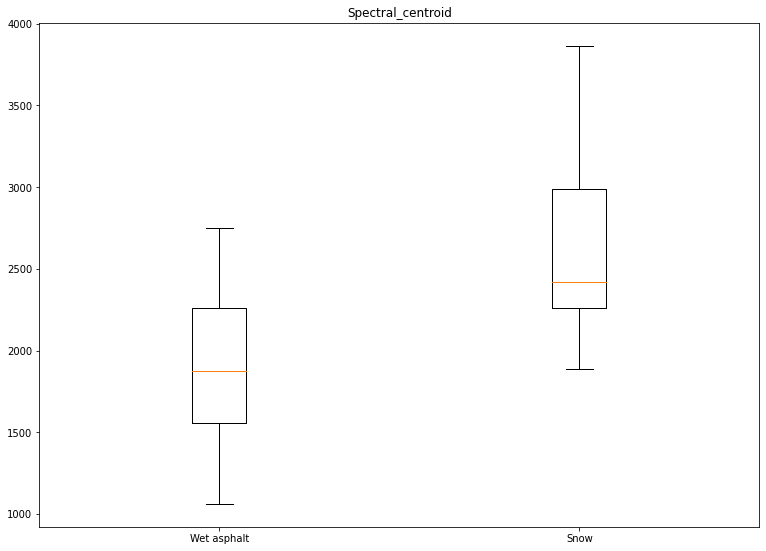

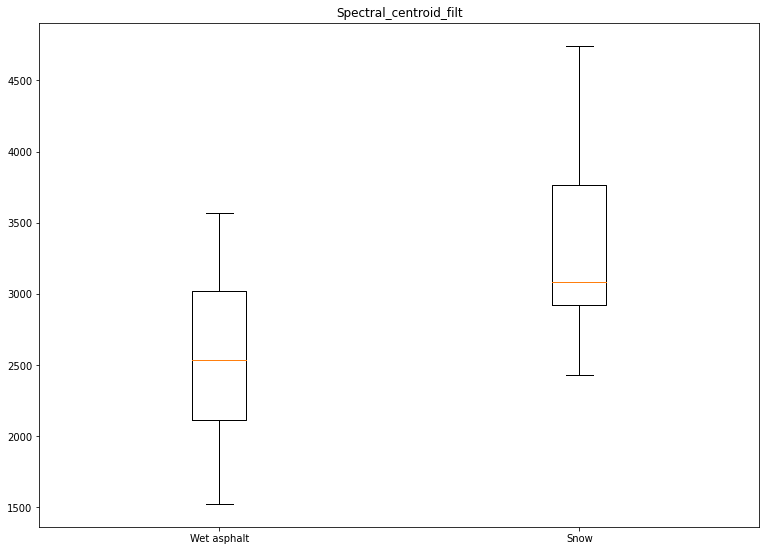

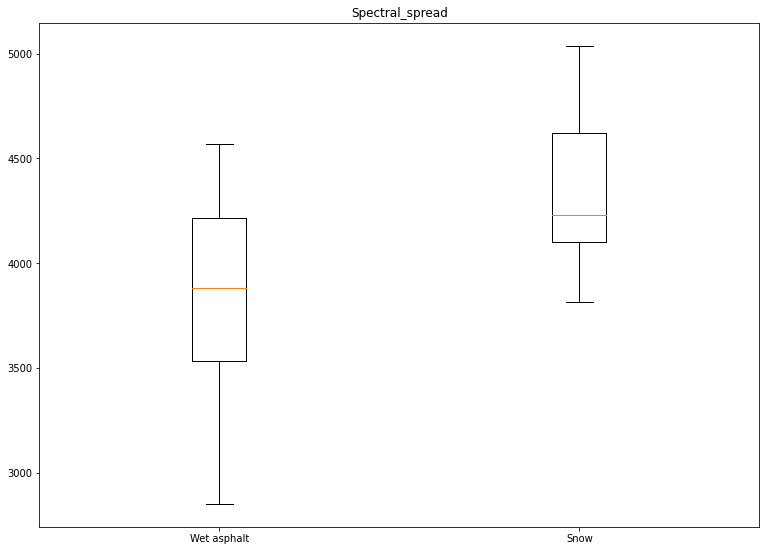

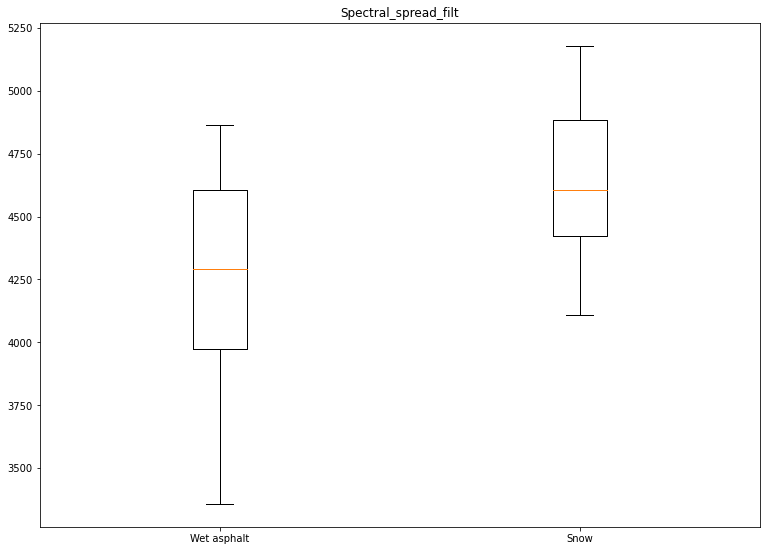

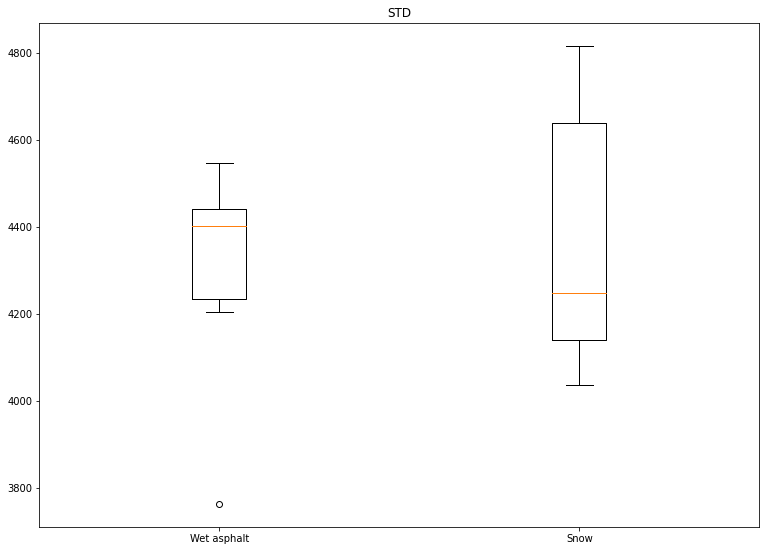

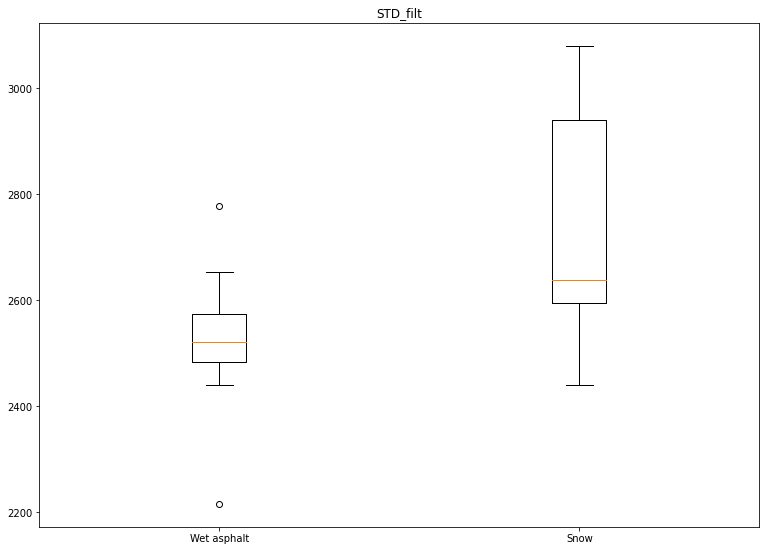

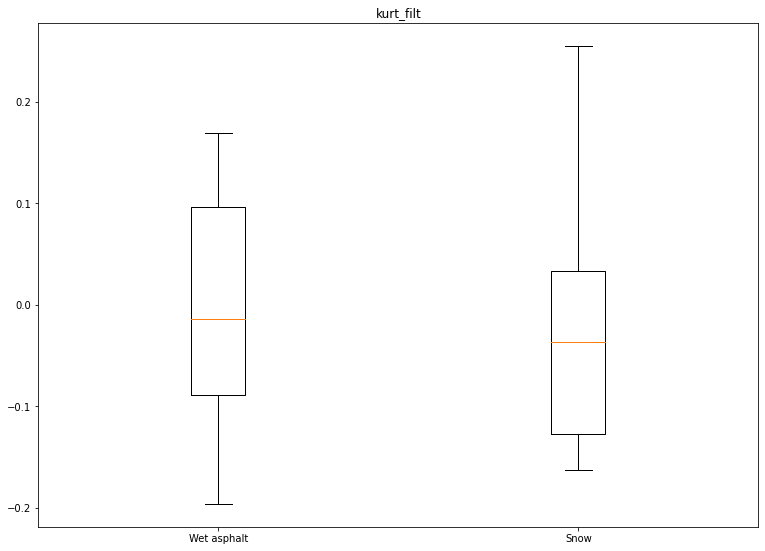

In [36]:
def getTypes(array):
    types=[]
    for i in range(len(array)):
        if(array[i] not in types):
            types.append(array[i])
    return types

def boxplot(dataframe,feature,ylim=(0,0)):
  labels=dataframe["Label"]
  types=getTypes(labels)
  values=np.array(dataframe[feature]).astype(np.float)
  x=[]
  for typ in types:
      x_type=[]
      for i in range(len(labels)):
        if(labels[i]==typ):
              x_type.append(values[i])
      x.append(x_type)
  fig = plt.figure(figsize =(10, 7))

  # Creating axes instance
  ax = fig.add_axes([0, 0, 1, 1])
  ax.set_title(feature)
  # Creating plot
  bp = ax.boxplot(x)
  ax.set_xticklabels(types)
  if ylim != (0,0) : plt.ylim(ylim[0],ylim[1])
  # show plot
  plt.show()
for feature in columnlist[1:]:
  boxplot(features_df,feature)

In [30]:
y=features_df["Label"]
X=features_df[columnlist[1:]]
X.head()

,RMS,RMS_filt,Zero_Cross,Zero_Cross_filt,Spectral_centroid,Spectral_centroid_filt,Spectral_spread,Spectral_spread_filt,STD,STD_filt,kurt_filt
0,11.84390029934529,2216.1630574775454,1934,2762,2749.6443901722096,3571.822404412853,4568.406951478484,4864.728135476897,3762.6230533404646,2216.1630571773135,0.1572069042386368
1,5.913404453424508,2441.180053181291,1400,2339,2208.8691735428197,2935.859568139889,4185.50282618633,4564.33297935398,4242.75799600883,2441.179372832663,-0.06036142712670767
2,11.966702985688858,2539.956237709434,1512,2729,2409.14764025699,3266.0057540009793,4307.327941650543,4733.431765330471,4407.869250529758,2539.956112094588,-0.19591831721816133
3,7.964129236605499,2481.6463630359103,1073,1847,1628.7744098314663,2304.8791516584324,3576.0093215136108,4075.940257257509,4429.833813358151,2481.646170437459,-0.05234576864329821
4,9.02700157137543,2652.849084335083,1707,2852,2621.0218448419882,3465.251019762206,4488.11883605754,4816.33855356548,4495.998048196208,2652.848992126169,0.08408454347124916


In [39]:
knn_model = KNeighborsClassifier(n_neighbors=3)
accuracy = round(np.mean(cross_val_score(knn_model, X, y, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1))*100,1)
print('KNN Leave one out cv accuracy:',accuracy,'%')

et_model = ExtraTreesClassifier(n_estimators=100)
accuracy = round(np.mean(cross_val_score(et_model, X, y, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1))*100,1)
print('Extra trees Leave one out cv accuracy:',accuracy,'%')

KNN Leave one out cv accuracy: 78.3 %
Extra trees Leave one out cv accuracy: 78.3 %
